**Generate Grapths - Opendirectories**
-------

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import dates
import matplotlib.pyplot as plt

In [3]:
import sys
cwd = sys.path[0]

In [4]:
plt.style.available
plt.style.use('bmh')

In [5]:
df = pd.read_csv('{}../subsets/SUBREDDIT_LINKS.csv'.format(cwd))

**1.0 Visualising All Subreddit Posts**

In [6]:
# Convert unix timecode to human readable date in the form (year-month)
df['TIME_%Y%M'] = df['TIME_GMT'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m'))
# Group dates by (year-month)
df_posts = df['TIME_%Y%M'].value_counts()
# Order series by date
df_posts.sort_index(inplace=True)

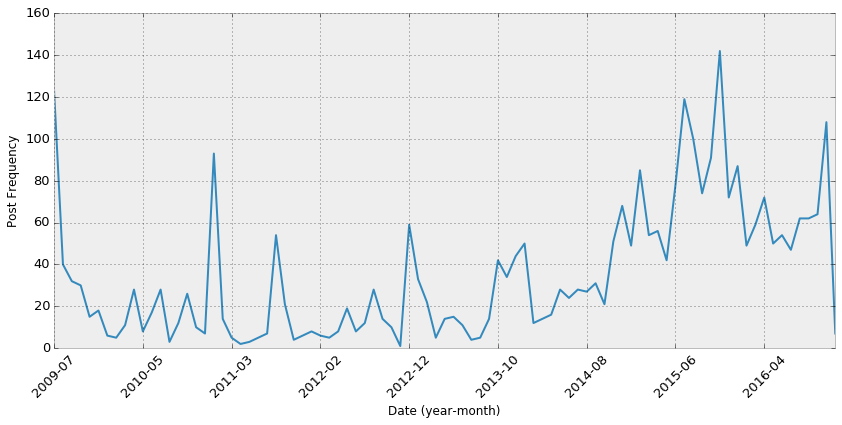

In [7]:
# Plot distribution
ax = df_posts.plot(figsize=(14, 6), rot=45, fontsize=13)
ax.set_xlabel('Date (year-month)')
ax.set_ylabel('Post Frequency')

In [8]:
# Save figure
fig=ax.get_figure()
fig.tight_layout()
fig.savefig('{}../figs/POSTS_VS_TIME.png'.format(cwd))

**1.1 Visualising Status Code Frequency**

In [9]:
# Get a frequency breakdown of status codes, null represents no connection
df_status = df['STATUS'].replace(np.nan, -1).astype(np.int)
df_status = df_status.replace(-1, 'null').value_counts()

# Normalise data
df_status = df_status.apply(lambda x: (x / df_status.sum()) * 100)

# Combine all codes which comprise < 1 % of total into other field
others_sum = df_status[(df_status < 1)].sum()
df_others = pd.Series([others_sum], index=['other'])

# Remove values which comprise less than 1% of the data.
df_status = df_status[(df_status >= 1)]

# Include 'others' section
df_status = df_status.append(df_others)

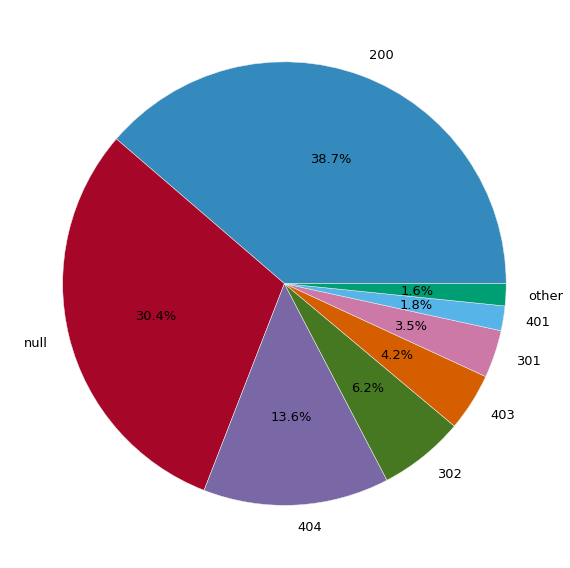

In [26]:
# Plot and save graph
ax = df_status.plot.pie(x=df_status.values,figsize=(14, 8),autopct='%0.1f%%', fontsize=13)
#ax.set_title('Server Status Code Distribution')
ax.set_ylabel('')
ax.set_aspect('equal')
fig=ax.get_figure()
fig.tight_layout()
fig.savefig('{}../figs/STATUS_FREQUENCY.png'.format(cwd))

**1.2 Visualising Connection Status Over Time**

In [11]:
df = pd.read_csv('{}../subsets/CONNECTION_ANALYTICS.csv'.format(cwd), index_col=0)

In [12]:
# Drop any status code where its historic contribution is always below 1%.
df = df[df  > 1].dropna(axis=1, how='all')

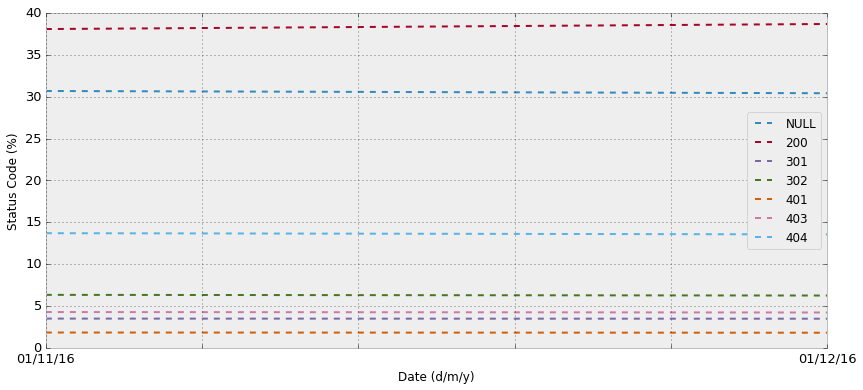

In [13]:
ax = df.plot(style='--', figsize=(14, 6), fontsize=13)
ax.set_ylabel('Status Code (%)')
ax.set_xlabel('Date (d/m/y)')

In [14]:
fig=ax.get_figure()
fig.tight_layout()
fig.savefig('{}../figs/DATE_STATUS_HISTORIC.png'.format(cwd))